On rajoute les données meteo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.cross_decomposition import PLSRegression

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [3]:
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
colonnes_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
tempo = []
for code in liste_stations_meteo:
    tempo += [tp + "_" + code for tp in colonnes_meteo]
colonnes_meteo_stations = tempo

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

# Val croisée

In [5]:
max_compo = 100

for curr_compo in tqdm(range(1, max_compo+1)):
    cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
    cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
    cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})
    
    for curr_split in range(9):
        
        # Entraintement
        curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
        curr_train_Y = mesures_train_Y[train_split_Y["Train_" + str(curr_split)]]
        
        curr_train_X_mean = curr_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
        curr_train_X_std = curr_train_X[liste_stations_debit + colonnes_meteo_stations].std()
        curr_train_X_standard = fct_Standardize(curr_train_X, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_train_X_standard["Date"] = curr_train_X["Date"]
        model = PLSRegression(n_components=curr_compo)
        model.fit(X = curr_train_X_standard[colonnes_meteo_stations],
                  Y = curr_train_X_standard[liste_stations_debit])
        
        # Predictions Standard
        curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
        curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
        liste_dates = curr_test_Y["Date"]
        curr_test_X_standard =fct_Standardize(curr_test_X, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit + colonnes_meteo_stations)
        curr_test_X_standard["Date"] = curr_test_X["Date"].values
        predictions_Y_standard = model.predict(curr_test_X_standard[colonnes_meteo_stations])
        predictions_Y_standard = pd.DataFrame(predictions_Y_standard, columns=liste_stations_debit)
        predictions_Y_standard["Date"] = curr_test_X_standard["Date"].values
        # Filtre sur les dates
        resultat = pd.DataFrame()
        for curr_date in liste_dates:
            resultat = pd.concat([resultat, predictions_Y_standard[predictions_Y_standard["Date"] == curr_date]])
        resultat = resultat.sort_values(by = "Date")
        predictions_Y_standard = resultat.copy()
        
        # Score standard
        curr_test_Y_standard = fct_Standardize(curr_test_Y, curr_train_X_mean,
                                                curr_train_X_std, liste_stations_debit)
        curr_test_Y_standard["Date"] = curr_test_Y["Date"]
        curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
        cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]
        
        # Score
        predictions_Y = fct_StandardizeInverse(predictions_Y_standard, curr_train_X_mean,
                                              curr_train_X_std, liste_stations_debit)
        predictions_Y["Date"] = predictions_Y_standard["Date"].values
        curr_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_RMSE["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
        curr_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_MAE["Split_" + str(curr_split)] = curr_MAE["MAE"]
        curr_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations_debit)
        cv_scores_R2["Split_" + str(curr_split)] = curr_R2["R2"]
    
    cv_moyen_RMSE_standard = []
    cv_moyen_MAE_standard = []
    cv_moyen_R2_standard = []
    
    cv_moyen_RMSE = []
    cv_moyen_MAE = []
    cv_moyen_R2 = []

    for code in liste_stations_debit:
        score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE_standard.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE_standard.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2_standard.append(score_R2)
        score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_RMSE.append(score_RMSE)
        score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_MAE.append(score_MAE)
        score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
        cv_moyen_R2.append(score_R2)

    cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
    cv_scores_RMSE_standard.to_csv("../Data/PLS_Meteo/CV_RMSE_standard_compo_" + str(curr_compo) + ".csv",
                          index=False)
    cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
    cv_scores_MAE_standard.to_csv("../Data/PLS_Meteo/CV_MAE_standard_compo_" + str(curr_compo) + ".csv",
                          index=False)
    cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
    cv_scores_R2_standard.to_csv("../Data/PLS_Meteo/CV_R2_standard_compo_" + str(curr_compo) + ".csv",
                          index=False)
    cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
    cv_scores_RMSE.to_csv("../Data/PLS_Meteo/CV_RMSE_compo_" + str(curr_compo) + ".csv",
                          index=False)
    cv_scores_MAE["Moyenne"] = cv_moyen_MAE
    cv_scores_MAE.to_csv("../Data/PLS_Meteo/CV_MAE_compo_" + str(curr_compo) + ".csv",
                          index=False)
    cv_scores_R2["Moyenne"] = cv_moyen_R2
    cv_scores_R2.to_csv("../Data/PLS_Meteo/CV_R2_compo_" + str(curr_compo) + ".csv",
                          index=False)

100%|██████████| 100/100 [16:13<00:00,  9.73s/it]


## Selection

In [6]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


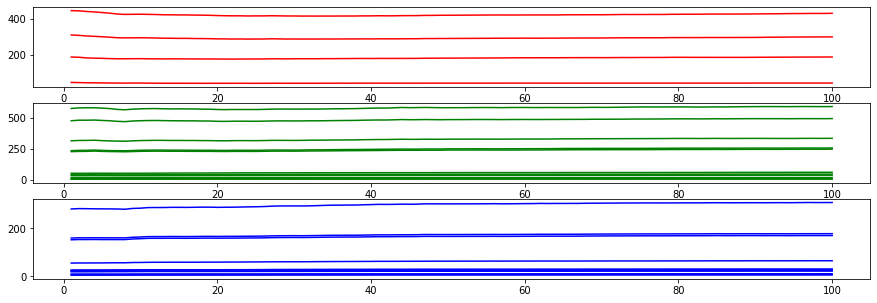

In [7]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_RMSE_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

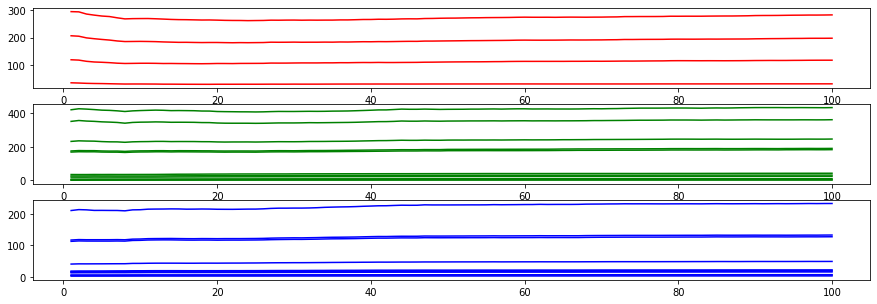

In [8]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_MAE_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

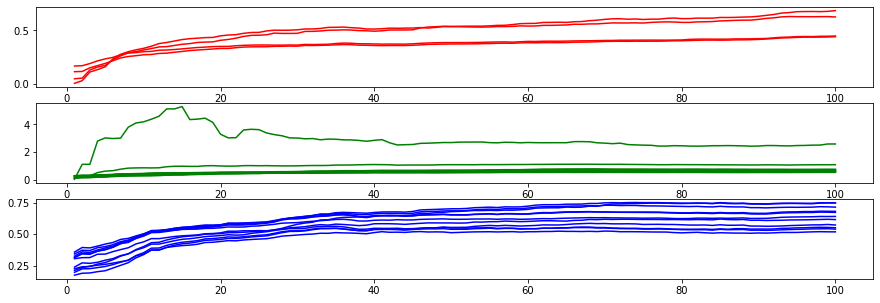

In [9]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_R2_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Standard

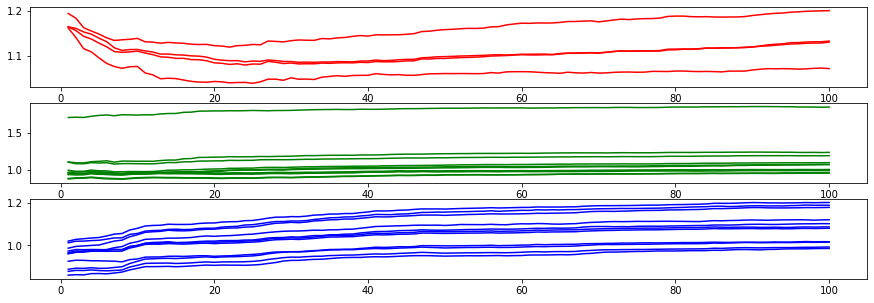

In [10]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_RMSE_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

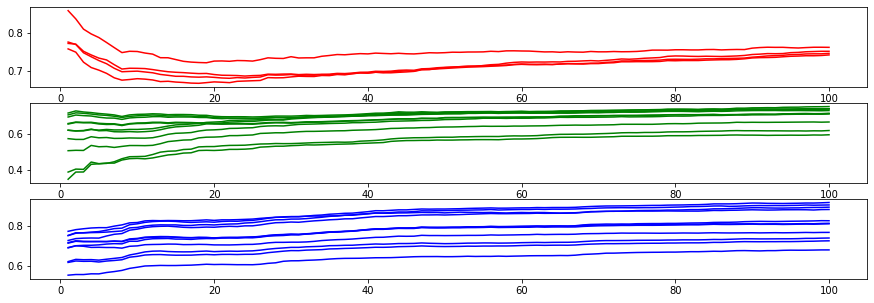

In [11]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_MAE_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

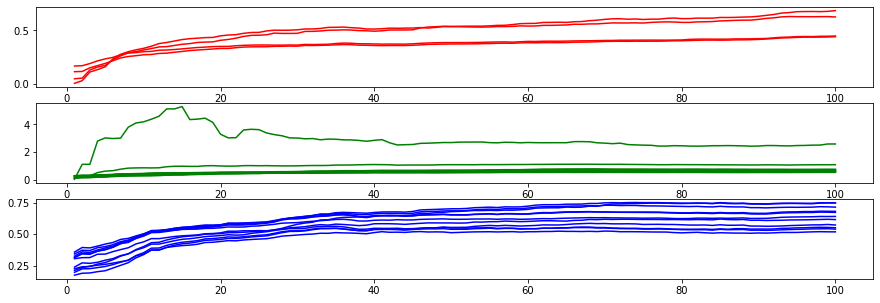

In [12]:
cv_moyen = pd.DataFrame()

for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_R2_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,5))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == list(cours_eau_couleur[cours_eau_couleur["Index"] == i]["Cours eau"])[0]]["Code station"])
    for code in stations:
        axs[i].plot(cv_moyen["N_Compo"], cv_moyen[code],
                   color = cours_eau_cmap(i))
plt.show()

## Moyen

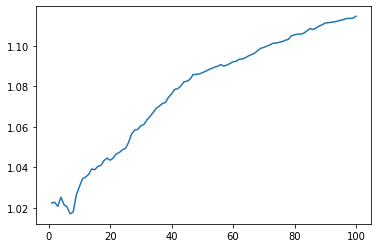

In [13]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_RMSE_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["N_Compo"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

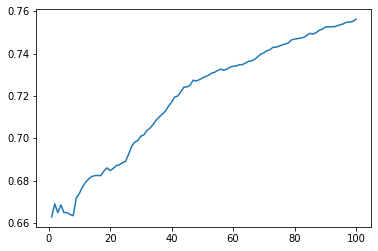

In [14]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_MAE_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["N_Compo"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

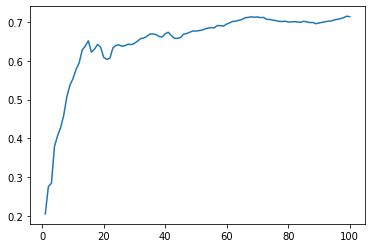

In [15]:
cv_moyen = pd.DataFrame()
for curr_compo in range(1, max_compo+1):
    curr_moyen = {}
    cv_scores = pd.read_csv("../Data/PLS_Meteo/CV_R2_standard_compo_" + str(curr_compo) + ".csv")
    for code in liste_stations_debit:
        curr_moyen[code] = list(cv_scores[cv_scores["Code station"] == code]["Moyenne"])
    curr_moyen = pd.DataFrame(curr_moyen)
    curr_moyen["N_Compo"] = curr_compo
    cv_moyen = pd.concat([cv_moyen, curr_moyen])

plt.plot(cv_moyen["N_Compo"], cv_moyen[liste_stations_debit].mean(axis = 1).values)

In [16]:
cv_moyen[liste_stations_debit].mean(axis = 1).values

array([0.20534774, 0.27572456, 0.28453736, 0.37983749, 0.40702582,
       0.42823587, 0.46000782, 0.50679511, 0.53709603, 0.55397406,
       0.57787834, 0.59446172, 0.62771698, 0.63801405, 0.65164034,
       0.62227379, 0.63002375, 0.64239634, 0.63513344, 0.60900047,
       0.60394234, 0.60641134, 0.63358842, 0.63995885, 0.64097857,
       0.63737069, 0.63955385, 0.64312227, 0.64164554, 0.64510738,
       0.65080684, 0.65732533, 0.65871863, 0.66286684, 0.66906575,
       0.66930715, 0.66771458, 0.6630694 , 0.66148091, 0.66988755,
       0.67382091, 0.66505496, 0.65808126, 0.65805031, 0.66014019,
       0.66889   , 0.67036522, 0.67380212, 0.67712832, 0.67676053,
       0.67795875, 0.67932153, 0.68237333, 0.68461512, 0.68547135,
       0.68533334, 0.69108458, 0.6905799 , 0.68967543, 0.69482686,
       0.69804243, 0.70167192, 0.70245049, 0.70480622, 0.70648422,
       0.71120326, 0.71199387, 0.71351158, 0.71228959, 0.71322502,
       0.71143047, 0.71185247, 0.70709834, 0.70671588, 0.70496

# Test

In [17]:
n_compo = 15

In [18]:
# Entraintement
mesures_train_X_mean = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit + colonnes_meteo_stations].std()
mesures_train_X_standard = fct_Standardize(mesures_train_X, 
                                           mesures_train_X_mean, mesures_train_X_std, 
                                           liste_stations_debit + colonnes_meteo_stations)
mesures_train_X_standard["Date"] = mesures_train_X["Date"]
model = PLSRegression(n_components=n_compo)
model.fit(X = mesures_train_X_standard[colonnes_meteo_stations],
          Y = mesures_train_X_standard[liste_stations_debit])

PLSRegression(n_components=15)

In [19]:
# Predictions Standard
liste_dates = mesures_test_Y["Date"]
mesures_test_X_standard =fct_Standardize(mesures_test_X, 
                                         mesures_train_X_mean, mesures_train_X_std, 
                                         liste_stations_debit + colonnes_meteo_stations)
mesures_test_X_standard["Date"] = mesures_test_X["Date"].values
predictions_test_Y_standard = model.predict(mesures_test_X_standard[colonnes_meteo_stations])
predictions_test_Y_standard = pd.DataFrame(predictions_test_Y_standard, columns=liste_stations_debit)
predictions_test_Y_standard["Date"] = mesures_test_X_standard["Date"].values

In [20]:
# Filtre sur les dates
resultat = pd.DataFrame()
for curr_date in liste_dates:
    resultat = pd.concat([resultat, predictions_test_Y_standard[predictions_test_Y_standard["Date"] == curr_date]])
resultat = resultat.sort_values(by = "Date")
predictions_test_Y_standard = resultat.copy()

In [21]:
mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                          liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]

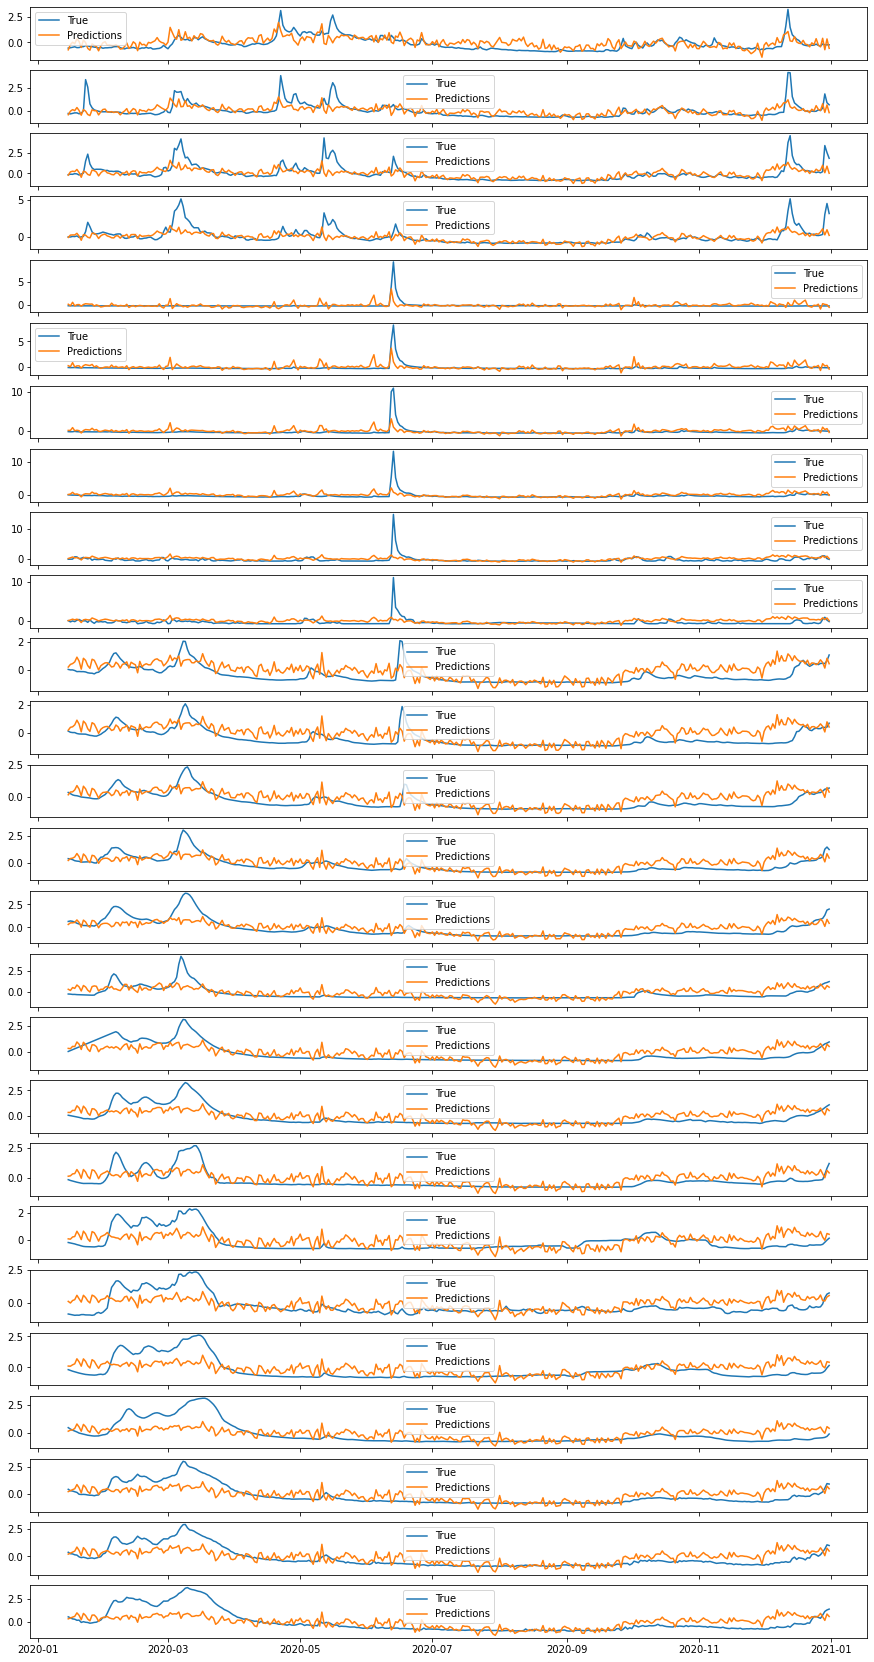

In [22]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard["Date"], mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard["Date"], predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [23]:
scores_rmse_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_mae_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_r2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse_standard["RMSE"],
                            "MAE": scores_mae_standard["MAE"],
                            "R2": scores_r2_standard["R2"]})
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.551448,0.420242,0.521386
1,O2620010,0.664758,0.416174,0.302261
2,O6140010,0.744626,0.450903,0.301075
3,O9000010,0.798657,0.465642,0.278702
4,K0030020,0.627486,0.283921,0.439455
5,K0100020,0.645604,0.354884,0.535378
6,K0260020,0.865846,0.445237,0.299112
7,K0550010,0.970699,0.534242,0.283817
8,K0690010,1.065763,0.590124,0.224273
9,K0910050,0.922727,0.597626,0.276715


In [24]:
test_scores_standard.to_csv("../Data/PLS_Meteo/Test_scores_standard.csv",
                   index = False)

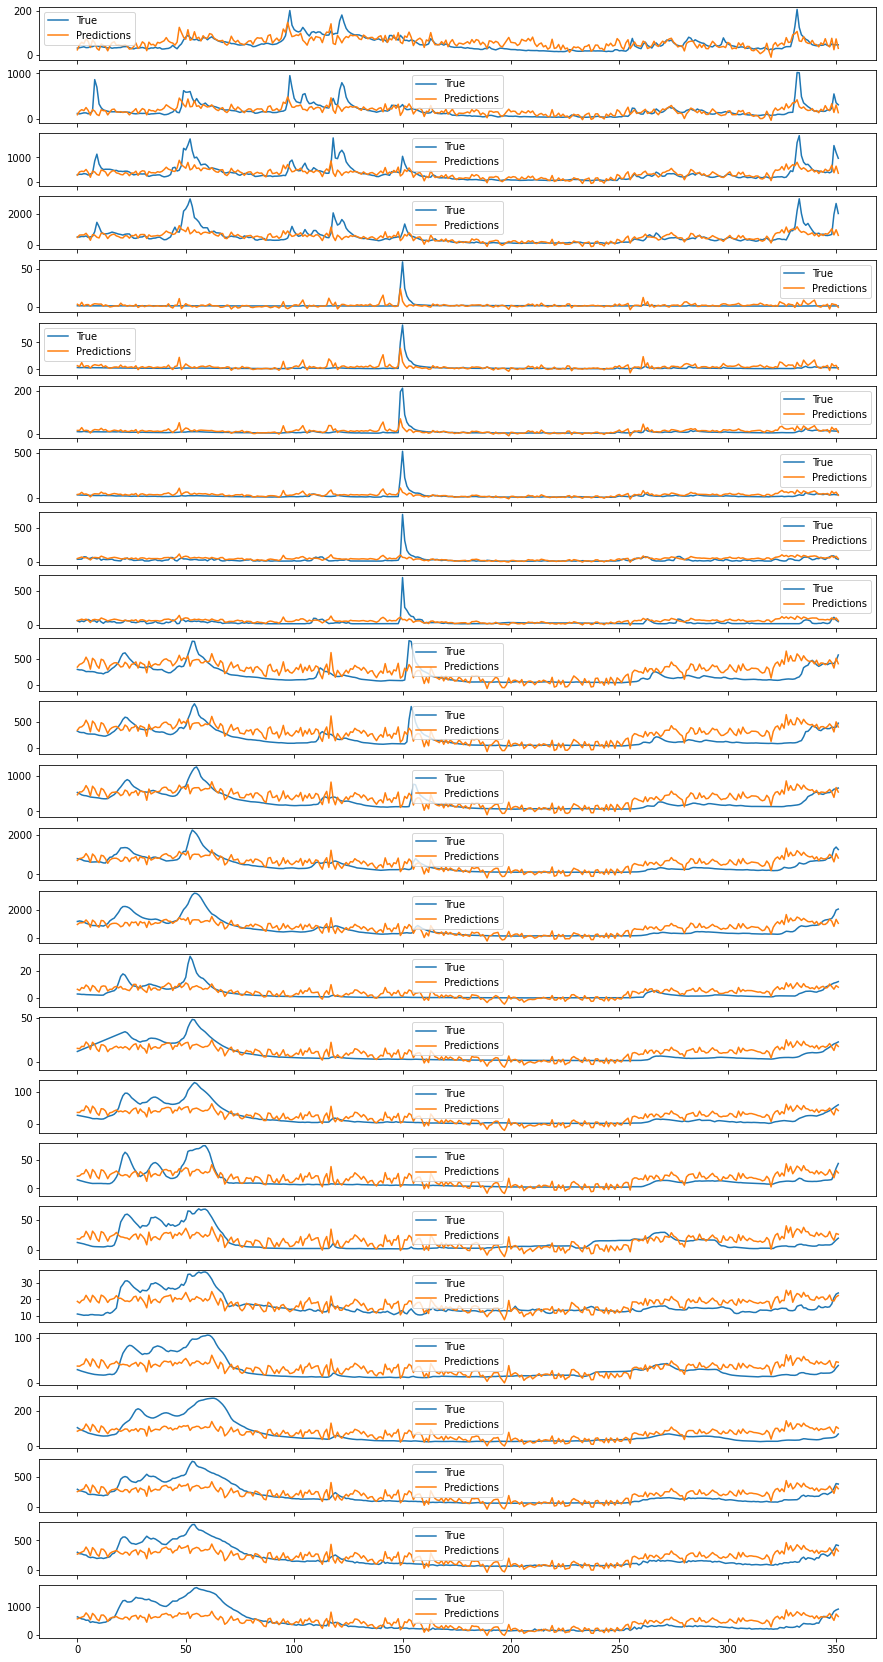

In [25]:
predictions_test_Y = fct_StandardizeInverse(predictions_test_Y_standard, mesures_train_X_mean,
                                              mesures_train_X_std, liste_stations_debit)
predictions_test_Y["Date"] = predictions_test_Y_standard["Date"].values

n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

In [26]:
scores_rmse = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_mae = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_r2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_rmse["RMSE"],
                            "MAE": scores_mae["MAE"],
                            "R2": scores_r2["R2"]})
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,25.599126,19.508342,0.521386
1,O2620010,131.764489,82.491451,0.302261
2,O6140010,245.012459,148.365668,0.301075
3,O9000010,388.319273,226.402223,0.278702
4,K0030020,3.848102,1.741170,0.439455
5,K0100020,6.078900,3.341525,0.535378
6,K0260020,16.039351,8.247781,0.299112
7,K0550010,35.364948,19.463750,0.283817
8,K0690010,47.678609,26.400126,0.224273
9,K0910050,53.280591,34.508430,0.276715


In [27]:
test_scores.to_csv("../Data/PLS_Meteo/Test_scores.csv",
                   index = False)